# Subject 1: CO2 concentration in the atmosphere since 1958

This notebook explores the long-term dataset of atmospheric CO₂ concentrations collected at the **Mauna Loa Observatory**, known as the **Keeling Curve**.

Primary objectives:

- Visualize the CO₂ trend and seasonal variations
- Separate the seasonal component
- Fit a linear trend model
- Forecast the CO₂ level up to 2025
- Compute yearly statistics

## The Keeling Curve and purpose of the quantitative analysis

Since 1958, American scientists Charles David Keeling has performed continuous measurement of atmospheric carbon dioxide (CO2) at the Mauna Loa Observatory in Hawaii.This long-term dataset has become known as the Keeling Curve, serving as clear evidence of the ongoing increase in atmospheric CO2 concentrations, which is primarily caused by human activity.

The initial objective of the observations was to study seasonal variation in CO2, which was occured because of natural processes such as photosynthesis and respiration. Over time, however, the focuses eventually turned to understanding the long-term upward trend in the context of climat change.This was occured due to the steady year over year increase in CO2 concentrations provided measurable evidence of impact of human activities, particularly fossil fuel combustions on the global ecosystem.

## Objectives of the Quantitative analysis

Quantitative evaluation aims to explore and model the time series of CO2 measurements from Mauna Loa.

Specifically, the objectives are:
    
- to create a plot showing the superposition of seasonal oscillations and a slower systematic trend.
- to separate the seasonal component and describe it.
- to construct a model for the long-term trend and estimates its parameters, i.e. slope and offset.
- to extrapolate the trend-up to the year 2025, providing a forecast for future changes in concentration of CO2 in atmosphere.

The data used in this quantitative analysis is a local copy of CO2 observations from the [Scripps CO2 Program](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html).

### Load and prepare the dataset to perform the quantitative analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

Importing the CO2 dataset, which was downloaded from the [Scripps CO2 Program website](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html).

As the original file includes metadata in the firs 61 rows, it is necessary to skip them when reading the file.
Afterwards, the column names was assigned.

In [2]:
df=pd.read_csv("monthly_in_situ_co2_mlo.csv", skiprows=61)
df.columns=['Year', 'Month', 'Excel', 'DecimalDate', 'CO2', 'CO2_season_adj', 
           'CO2_fit', 'CO2_adj_fit', 'CO2_filled', 'CO2_adj_filled', 'Sta']

## Filter out invalid of missing values

Some rows may contain non-numeric values, particularly in the "Year" columns

In [3]:
df=df[pd.to_numeric(df['Year'], errors='coerce').notnull()].copy()

The "Year" and "Month" columns were converted to integers, which ensure the CO2 values are numeric.

In [4]:
df['Year']=df['Year'].astype(int)
df['Month']=df['Month'].astype(int)
df['CO2']=pd.to_numeric(df['CO2'], errors='coerce')

A full datetime column was created to represent mid-month measurements. 

In [5]:
df['Date']=pd.to_datetime(dict(Year=df['Year'], Month=df['Month'], Day=15))

**"Date"** column was set as the index of the DataFrame to facilitate time series analysis

In [6]:
df=df[df['CO2']>0]
df.set_index('Date', inplace=True)

## Plot the Raw CO2 time series

It is possible to visualize the monthly CO2 measurement from the **Mauna Loa Observatory**.

The first prot illustrates the raw atmospheric CO2 concentrations over time, showing both seasonal periodic oscillations and a long-term upward trend.

The graph below demonstrates the measured atmospheric CO2 concentration at Mauna Loa Observatory from 1958 to the present. As a result of quantitative analysis, it has been revealed two key features:

- Upward long-term trend in CO2 level, indicating a continuous increase over the decades.
- A periodic oscillations, reflecting seasonal variation in CO2 concentration within each year.

These seasonal cycles are caused by natural processes and human acttivities, which dominate global CO2 exchange.

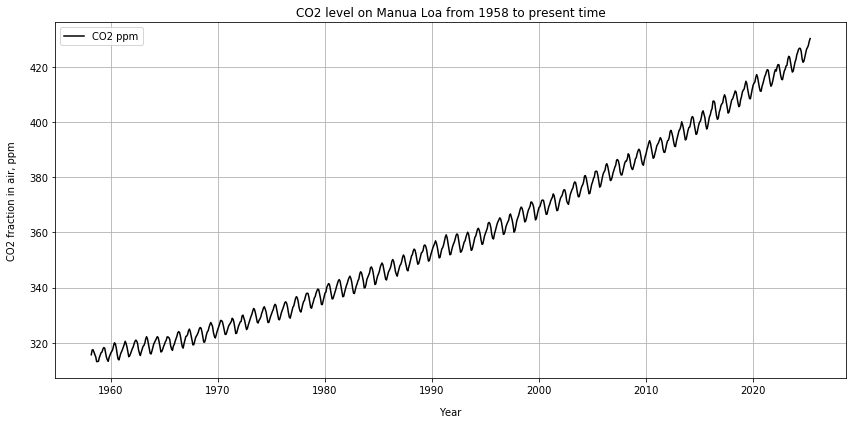

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['CO2'], label='CO2 ppm', color='black')
plt.title('CO2 level on Manua Loa from 1958 to present time')
plt.xlabel('Year',labelpad=12)
plt.ylabel('CO2 fraction in air, ppm', labelpad=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Seasonal oscillation of CO2

We performed a seasonal decomposition of the CO2 data in order to separate the peoridic component from the trend and residuals. An additive model was used with frequency of 12 months.

In [8]:
Decomposition=seasonal_decompose(df['CO2'], model='additive', freq=12)
#drop missing values to ensure exact quantitative analysis
Seasonal=Decomposition.seasonal.dropna()

Now, we convert the seasonal component to a DataFrame and extract the month from the datetime index for monthly grouping.Furthermore, the average seasonal deviation was computed for each month by grouping the data by month.

In [9]:
Seasonal_Monthly=Seasonal.to_frame(name='Seasonality')
Seasonal_Monthly['Month']=Seasonal_Monthly.index.month
Monthly_Avg=Seasonal_Monthly.groupby('Month')['Seasonality'].mean()

## Plot the average seasonal oscillation og CO2 concentration

The plot below presents the mean deviation for each month across all years, clearly highlighting the periodic nature of CO2 level.

Moreover, the average seasonal variation in CO2 concentration is observed accros differnt months of the year.
Notably, CO2 levels peak in May, when plant growth has not yeat removed considerable amount of CO2 from the atmosphere.
Conversely, the lowes concentration occur in September and October, due to enhanced photosyntetic actrivity during summer, when vegetation actively absorbs CO2.
After October, CO2 concentrations begin to rise again, mainly because deciduous plants shed their leaves, and photosynthesis slows down, while decomposition process continue, realising CO2 back into the atmosphere. This seasonal CO2 cycle leads to the regular annual fluctuation in its concentration.

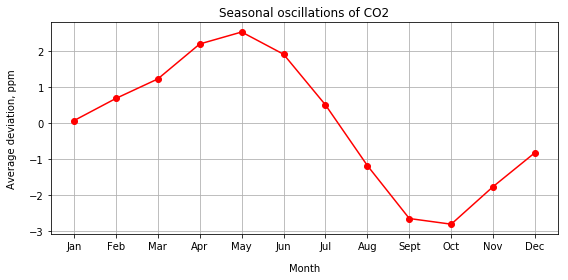

In [10]:
plt.figure(figsize=(8,4))
plt.plot(Monthly_Avg.index, Monthly_Avg.values, marker='o', linestyle='-', color='red')
plt.title('Seasonal oscillations of CO2')
plt.xlabel('Month',labelpad=12)
plt.ylabel('Average deviation, ppm', labelpad=12)

plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])

plt.grid(True)
plt.tight_layout()
plt.show()

## Linear Trend Evaluation and Extrapolation

We construct a linear regression model to estimate the long-term trend in CO2 concentration:

- the model was computed manually using the least squares method.
- The trend was extrapolated to predict CO2 level up to the year 2025.

In [11]:
df_clean = df.dropna(subset = ['CO2', 'DecimalDate']).copy()
df_clean['CO2']=pd.to_numeric(df_clean['CO2'], errors='coerce')
df_clean['DecimalDate']=pd.to_numeric(df_clean['DecimalDate'], errors='coerce')

df_clean=df_clean.dropna(subset = ['CO2', 'DecimalDate'])
x = df_clean['DecimalDate'].values
y = df_clean['CO2'].values

x_mean = np.mean(x)
y_mean = np.mean(y)

numerator = np.sum((x-x_mean)*(y-y_mean))
denominator = np.sum((x-x_mean)**2)

a_tr = numerator / denominator
b_tr = y_mean - a_tr*x_mean

y_pred_tr =  a_tr*x + b_tr

x_future = np.arange(x.max(), 2026.0, 1/12)
y_future_pred = a_tr*x_future + b_tr

## Plot of the Linear Trend and Extrapolated CO2 Level

This plot combined three elements:

- Trend line (red dashed) is a linear regression model showing the long-term increase in 
   atmospheric CO2.
- Observed variotion in CO2 concentrations (black lines) is actual monthly measurement.
- Extrapolated trend (blue dotted) is presicted CO2 values up to the year 2025 based in the model.

In this plot, the observed short-term variability is separated from the long-term systematic rise in CO2 concentrations.

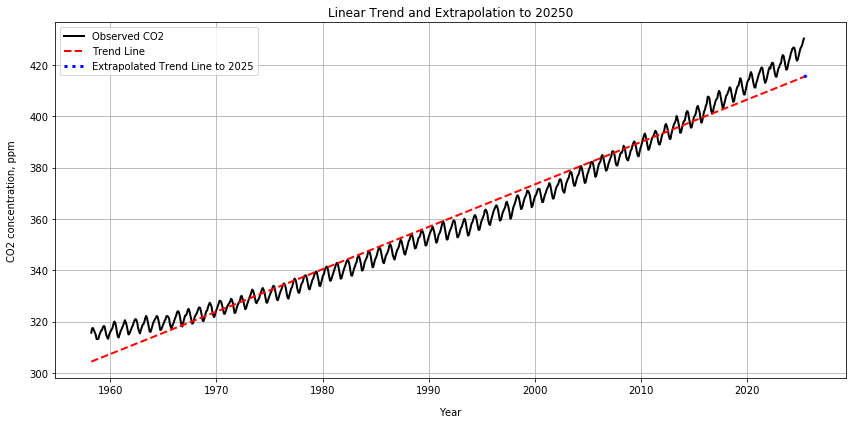

In [12]:
plt.figure(figsize=(12,6))

plt.plot(x,y, label='Observed CO2', color='black', linewidth=2)

plt.plot(x,y_pred_tr, label='Trend Line', color='red', linestyle='--', linewidth=2)
plt.plot(x_future, y_future_pred, label='Extrapolated Trend Line to 2025', color='blue', linestyle=':', linewidth=3)
plt.xlabel('Year', labelpad=12)
plt.ylabel('CO2 concentration, ppm', labelpad=12)
plt.title('Linear Trend and Extrapolation to 20250')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Yearly CO₂ Statistics

In this section, the dataset is grouped by year to compute key statistics for atmospheric CO₂ concentration: minimum, maximum, and mean values for each year. This allows us to observe not only the general trend over time but also the seasonal variation within each year.

In [13]:
yearly_stats=df.groupby('Year')['CO2'].agg(['min', 'max', 'mean']).reset_index()
yearly_stats.columns

print(yearly_stats)

    Year     min     max        mean
0   1958  313.21  317.51  315.335000
1   1959  313.33  318.29  315.980833
2   1960  313.83  320.03  316.909167
3   1961  314.99  320.58  317.643333
4   1962  315.42  321.02  318.454167
5   1963  315.98  322.24  318.991667
6   1964  316.71  322.25  319.202222
7   1965  317.30  322.17  320.037500
8   1966  318.10  324.08  321.367500
9   1967  319.25  325.00  322.178333
10  1968  320.25  325.57  323.050000
11  1969  321.78  327.38  324.620833
12  1970  323.06  328.13  325.681667
13  1971  323.36  328.93  326.320000
14  1972  324.84  330.07  327.456667
15  1973  327.19  332.48  329.681667
16  1974  327.38  333.10  330.250833
17  1975  328.35  333.98  331.160833
18  1976  328.95  334.89  332.161667
19  1977  331.17  336.76  333.910833
20  1978  332.56  338.02  335.515000
21  1979  333.87  339.48  336.860833
22  1980  335.90  341.48  338.700000
23  1981  336.71  342.93  339.951667
24  1982  337.88  344.16  341.150833
25  1983  339.89  345.77  342.798333
2

## Conclusion

Thus, the measurements of CO₂ concentration collected at the Mauna Loa Observatory show a gradual increase from 315.335 ppm in 1958 to 424.348 ppm in 2024. This rise is primarily attributed to the burning of fossil fuels and has been accelerating in recent years. Since CO₂ is a greenhouse gas, this upward trend has significant implications for future global warming.